In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 34.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
from os import listdir
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.transform import resize
from skimage.io import imread
import pandas as pd
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
directory_root = '/content/drive/MyDrive/Crop Disease/Image Data base'
categories = listdir(directory_root)


In [ ]:
len(categories)

29

In [ ]:
num_classes = 23
input_shape = (150,150,3)

In [ ]:
num_classes

23

In [ ]:
img_data_arr=[] #input array
target_arr=[] #output array
file_path = []
label_arr = []

for i,plant_folder in enumerate(categories):
    
    if plant_folder != 'Healthy':
      print(f'loading... category : {plant_folder}')
      # path=os.path.join(directory_root,i)
      plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

      if len(plant_disease_folder_list) >= 150:
        for img in plant_disease_folder_list[:150]:
            # print(img)
            directory = f'{directory_root}/{plant_folder}/{img}'
            img_array=imread(directory)
            img_resized=resize(img_array,(150,150,3))
            img_data_arr.append(img_resized)
            target_arr.append(i)
            label_arr.append(plant_folder)
            file_path.append(directory)
    # print(f'loaded category:{plant_folder} successfully')

loading... category : algal leaf in tea
loading... category : anthracnose in tea
loading... category : Apple Apple scab
loading... category : Apple Black rot
loading... category : Apple Cedar apple rust
loading... category : Bacterial leaf blight in rice leaf
loading... category : bird eye spot in tea
loading... category : Blight in corn Leaf
loading... category : brown blight in tea
loading... category : Brown spot in rice leaf
loading... category : cabbage looper
loading... category : Cercospora leaf spot
loading... category : Cherry (including sour) Powdery mildew
loading... category : Common Rust in corn Leaf
loading... category : Grape Black rot
loading... category : Gray Leaf Spot in corn Leaf
loading... category : lemon canker
loading... category : Nitrogen deficiency in plant
loading... category : potassium deficiency in plant
loading... category : Potato Early blight
loading... category : Potato Late blight
loading... category : Sogatella rice
loading... category : Tomato Bact

26

In [ ]:
plant_folder = 'Healthy'
plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

  
for h_folder in plant_disease_folder_list[1:2]:

  print(f'loading... category : {h_folder}')
  h_dir = listdir(f'{directory_root}/{plant_folder}/{h_folder}')

  for image in h_dir[:150]:

    image_directory = f'{directory_root}/{plant_folder}/{h_folder}/{image}'
    img_array=imread(directory)
    img_resized=resize(img_array,(150,150,3))
    img_data_arr.append(img_resized)
    target_arr.append(categories.index(plant_folder))
    label_arr.append(plant_folder)
    file_path.append(directory)

loading... category : Blueberry healthy


In [ ]:
num_classes = len(set(label_arr))
num_classes

23

In [ ]:
df = pd.DataFrame({'Labels':label_arr})

In [ ]:
df['Category'] = pd.factorize(df['Labels'], sort=False)[0]

In [ ]:
df

,Labels,Category
0,algal leaf in tea,0
1,algal leaf in tea,0
2,algal leaf in tea,0
3,algal leaf in tea,0
4,algal leaf in tea,0
...,...,...
3445,Healthy,22
3446,Healthy,22
3447,Healthy,22
3448,Healthy,22


In [ ]:
len(img_data_arr)

1920

In [ ]:
x = np.array(img_data_arr)
y = df.Category

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.80,random_state=77,stratify=y)
# x_train,x_val,y_train,y_val=train_test_split(x_train_val,y_train_val,train_size=0.90,random_state=77,stratify=y_train_val)


# Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 150  # We'll resize input images to this size
patch_size = 15  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [ ]:
len(x_train)

2760

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 150 X 150
Patch size: 15 X 15
Patches per image: 100
Elements per patch: 675


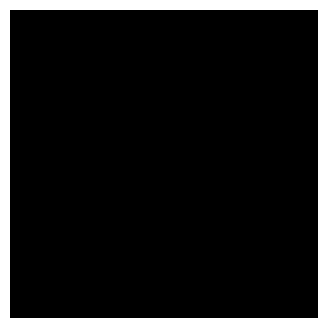

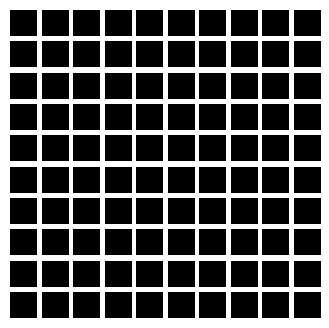

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes

23

# ViT Model Construction

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
model = create_vit_classifier()


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 150, 150, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 675)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 100, 64)      49664       ['patches_1[0][0]']          

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
10/10 [==============================] - 172s 15s/step - loss: 3.9070 - accuracy: 0.1731 - top-5-accuracy: 0.5020 - val_loss: 1.9952 - val_accuracy: 0.3297 - val_top-5-accuracy: 0.7899
Epoch 2/100
10/10 [==============================] - 131s 13s/step - loss: 2.3766 - accuracy: 0.2979 - top-5-accuracy: 0.7053 - val_loss: 1.7245 - val_accuracy: 0.4058 - val_top-5-accuracy: 0.8551
Epoch 3/100
10/10 [==============================] - 131s 13s/step - loss: 2.0326 - accuracy: 0.3623 - top-5-accuracy: 0.8060 - val_loss: 1.5691 - val_accuracy: 0.4348 - val_top-5-accuracy: 0.9094
Epoch 4/100
10/10 [==============================] - 127s 13s/step - loss: 1.8449 - accuracy: 0.4211 - top-5-accuracy: 0.8349 - val_loss: 1.3810 - val_accuracy: 0.5181 - val_top-5-accuracy: 0.9348
Epoch 5/100
10/10 [==============================] - 128s 13s/step - loss: 1.6461 - accuracy: 0.4444 - top-5-accuracy: 0.8752 - val_loss: 1.2656 - val_accuracy: 0.5507 - val_top-5-accuracy: 0.9275
Epoch 6/100
10/

In [ ]:
x_train_new,x_test_new,y_train_new,y_test_new=train_test_split(x_train,y_train,train_size=0.80,random_state=77,stratify=y_train)

In [ ]:
score = vit_classifier.evaluate(x_test, y_test)

22/22 [==============================] - 11s 486ms/step - loss: 0.4734 - accuracy: 0.8986 - top-5-accuracy: 0.9870


In [ ]:
print("Test Accuracy is %.2f" % score[1])


Test Accuracy is 0.90


3/3 [==============================] - 16s 4s/step - loss: 1.2011 - accuracy: 0.7420 - top-5-accuracy: 0.9609


[1.2010527849197388, 0.7420290112495422, 0.960869550704956]

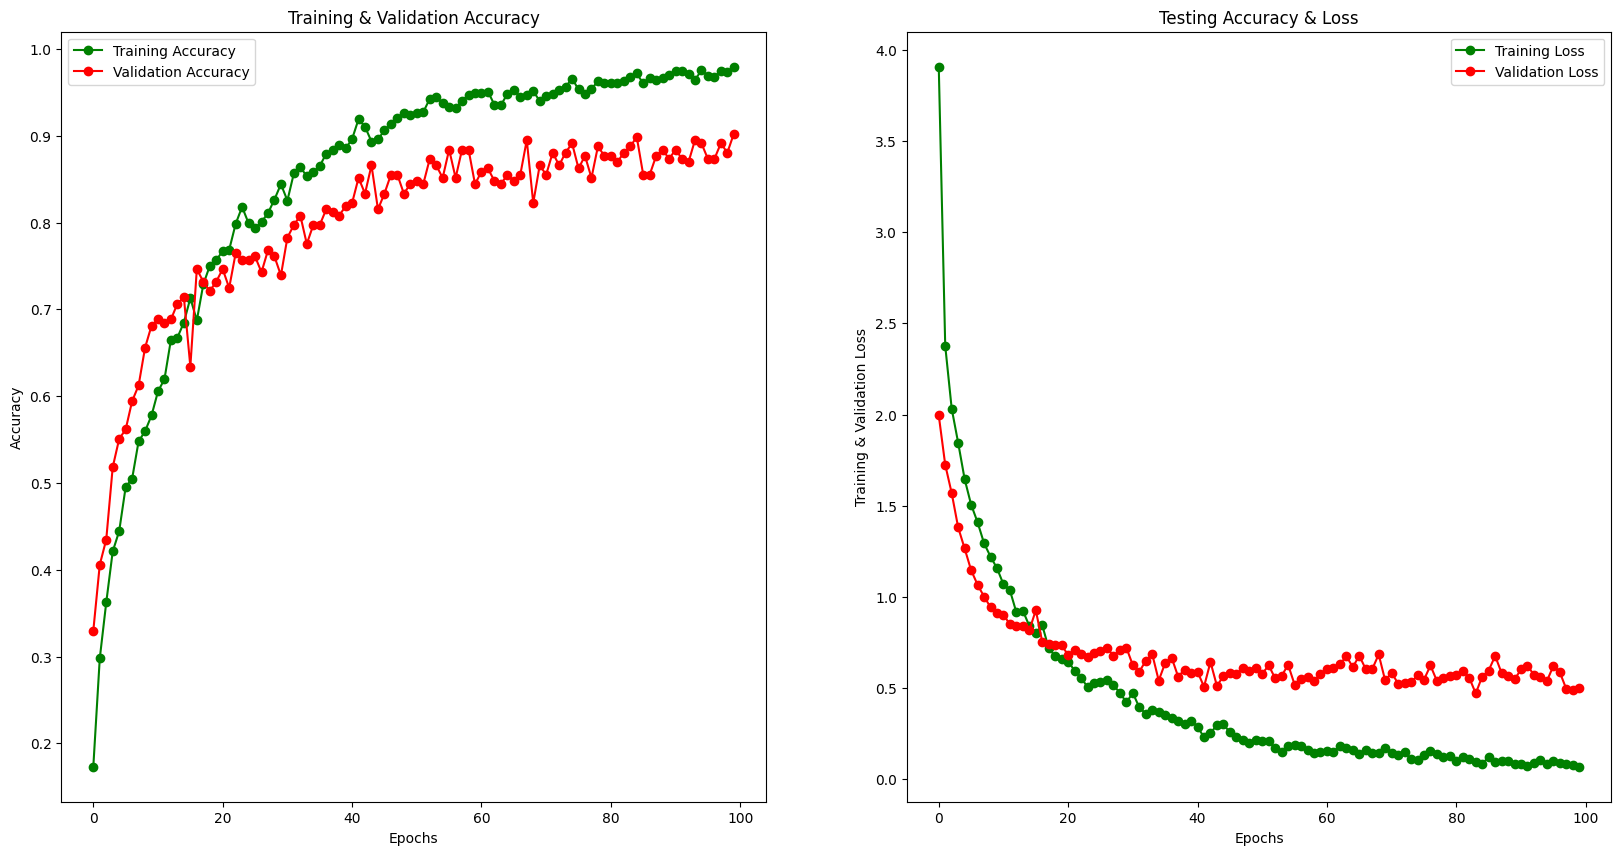

In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
vit_classifier.save('/content/drive/MyDrive/VIT')




In [ ]:
# serialize model to JSON
model_json = vit_classifier.to_json()
with open("VITmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
vit_classifier.save_weights("VITmodel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
predictions = vit_classifier.predict(x_test).round()

22/22 [==============================] - 11s 491ms/step


In [ ]:
pred_label = np.argmax(predictions, axis=1)


# Confusion Matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_label)


In [ ]:
classes = list(set(label_arr))

In [ ]:
classes

['Tomato Bacterial spot',
 'Grape Black rot',
 'Apple Black rot',
 'Cercospora leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Cherry (including sour) Powdery mildew',
 'algal leaf in tea',
 'anthracnose in tea',
 'lemon canker',
 'Healthy',
 'Tomato Early blight',
 'Tomato Septoria leaf spot',
 'Potato Late blight',
 'Apple Apple scab',
 'bird eye spot in tea',
 'Apple Cedar apple rust',
 'cabbage looper',
 'Tomato Target Spot',
 'brown blight in tea',
 'Common Rust in corn Leaf',
 'Potato Early blight',
 'Blight in corn Leaf',
 'Gray Leaf Spot in corn Leaf']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_label, target_names = classes))

                                             precision    recall  f1-score   support

                      Tomato Bacterial spot       0.93      0.93      0.93        30
                            Grape Black rot       0.78      0.93      0.85        30
                            Apple Black rot       0.93      0.83      0.88        30
                       Cercospora leaf spot       0.97      0.93      0.95        30
Tomato Spider mites Two spotted spider mite       0.81      0.97      0.88        30
     Cherry (including sour) Powdery mildew       0.92      0.73      0.81        30
                          algal leaf in tea       0.91      1.00      0.95        30
                         anthracnose in tea       0.94      0.97      0.95        30
                               lemon canker       0.76      0.87      0.81        30
                                    Healthy       0.87      0.87      0.87        30
                        Tomato Early blight       0.96      0.87

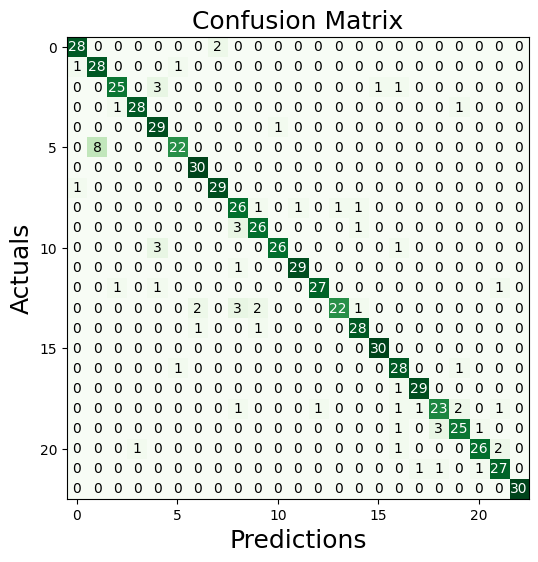

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test,predictions)
 
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()